## Churn prediction using Random Forest

In this project we try to predict if a customer is going to churn using the random forest classifier. The data comes from a publically available dataset for 3333 customers.

In [24]:
# First we import some modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.cross_validation import train_test_split, KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix, classification_report

In [32]:
# We import the function plot_roc from the file roc.py
import sys
sys.path.append('../code/')
from roc import plot_roc

We start by looking at the dataset.

In [4]:
df = pd.read_csv('../data/churn.csv')
df.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
State             3333 non-null object
Account Length    3333 non-null int64
Area Code         3333 non-null int64
Phone             3333 non-null object
Int'l Plan        3333 non-null object
VMail Plan        3333 non-null object
VMail Message     3333 non-null int64
Day Mins          3333 non-null float64
Day Calls         3333 non-null int64
Day Charge        3333 non-null float64
Eve Mins          3333 non-null float64
Eve Calls         3333 non-null int64
Eve Charge        3333 non-null float64
Night Mins        3333 non-null float64
Night Calls       3333 non-null int64
Night Charge      3333 non-null float64
Intl Mins         3333 non-null float64
Intl Calls        3333 non-null int64
Intl Charge       3333 non-null float64
CustServ Calls    3333 non-null int64
Churn?            3333 non-null object
dtypes: float64(8), int64(8), object(5)
memory usage: 546.9+ KB


In [6]:
df['Int\'l Plan'].unique()

array(['no', 'yes'], dtype=object)

We notice that some boolean columns have string values, so we replace them by `True` and `False`.

In [7]:
df.replace(['False.', 'True.'], [False, True], inplace=True)
df.replace(['no', 'yes'], [False, True], inplace=True)

In [8]:
df.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,False,True,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False
1,OH,107,415,371-7191,False,True,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False
2,NJ,137,415,358-1921,False,False,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False
3,OH,84,408,375-9999,True,False,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False
4,OK,75,415,330-6626,True,False,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
State             3333 non-null object
Account Length    3333 non-null int64
Area Code         3333 non-null int64
Phone             3333 non-null object
Int'l Plan        3333 non-null bool
VMail Plan        3333 non-null bool
VMail Message     3333 non-null int64
Day Mins          3333 non-null float64
Day Calls         3333 non-null int64
Day Charge        3333 non-null float64
Eve Mins          3333 non-null float64
Eve Calls         3333 non-null int64
Eve Charge        3333 non-null float64
Night Mins        3333 non-null float64
Night Calls       3333 non-null int64
Night Charge      3333 non-null float64
Intl Mins         3333 non-null float64
Intl Calls        3333 non-null int64
Intl Charge       3333 non-null float64
CustServ Calls    3333 non-null int64
Churn?            3333 non-null bool
dtypes: bool(3), float64(8), int64(8), object(2)
memory usage: 478.5+ KB


We can safely make an assumption that the `State` and `Phone` columns are not relevant predictors.

In [10]:
df.drop(['State', 'Phone'], axis=1, inplace=True)

In [11]:
df.columns

Index([u'Account Length', u'Area Code', u'Int'l Plan', u'VMail Plan',
       u'VMail Message', u'Day Mins', u'Day Calls', u'Day Charge', u'Eve Mins',
       u'Eve Calls', u'Eve Charge', u'Night Mins', u'Night Calls',
       u'Night Charge', u'Intl Mins', u'Intl Calls', u'Intl Charge',
       u'CustServ Calls', u'Churn?'],
      dtype='object')

We separate the target `Churn?` and the feature space.

In [12]:
y = df.pop('Churn?').values
X = df.values

Next we split `X` and `y` into train and test sets.

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

We start by train a random forest classifier with default parameters.

In [14]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

Calculate the accuracy:

In [15]:
rf.score(X_test, y_test)

0.93645083932853712

Look at the confusion matrix and classification report.

In [17]:
y_predict = rf.predict(X_test)
print "Confusion matrix:\n\n", confusion_matrix(y_test, y_predict)
print "\n\nClassification Report:\n\n", classification_report(y_test, y_predict)

Confusion matrix:

[[692   9]
 [ 44  89]]


Classification Report:

             precision    recall  f1-score   support

      False       0.94      0.99      0.96       701
       True       0.91      0.67      0.77       133

avg / total       0.94      0.94      0.93       834



Now we build the RandomForestClassifier again setting the out of bag parameter -- `oob_score` to be `True`.

In [18]:
rf_oob = RandomForestClassifier(oob_score=True, n_estimators=100)
rf_oob.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

In [19]:
print "Accuracy:\t", rf_oob.score(X_test, y_test)
y_predict = rf.predict(X_test)
print "\nConfusion matrix:\n\n", confusion_matrix(y_test, y_predict)
print "\nClassification Report:\n\n", classification_report(y_test, y_predict)

Accuracy:	0.950839328537

Confusion matrix:

[[692   9]
 [ 44  89]]

Classification Report:

             precision    recall  f1-score   support

      False       0.94      0.99      0.96       701
       True       0.91      0.67      0.77       133

avg / total       0.94      0.94      0.93       834



We notice the the scores are very close to each other.

We would like to give advice for what to focus on to prevent churn. To see what specifics about a user we should focus on changing in order to make them not churn, we use `sklearn`'s model to get the top five feature importances.

In [20]:
df.columns[np.argsort(rf_oob.feature_importances_)][::-1][:5]

Index([u'Day Charge', u'Day Mins', u'CustServ Calls', u'Int'l Plan',
       u'Eve Mins'],
      dtype='object')

In [21]:
rf_oob.feature_importances_[np.argsort(rf_oob.feature_importances_)][::-1][:5]

array([ 0.13878591,  0.1302041 ,  0.12560772,  0.07529931,  0.07271285])

To potentially limit churn, we evaluate the these features for the customers who are exhibiting churn and resolve those issues.

Now we try modifying the number of trees. The default is 10 trees. We input different values for the number of trees and make a graph of the number of trees versus the accuracy score. 

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
acc_scores = []
tree_counts = []
for num_trees in xrange(1, 21, 2):
    scores = []
    for i in xrange(5):
        rf = RandomForestClassifier(n_estimators=num_trees)
        rf.fit(X_train, y_train)
        score = rf.score(X_test, y_test)
        scores.append(score)
    acc_scores.append(np.mean(scores))    
    tree_counts.append(num_trees)


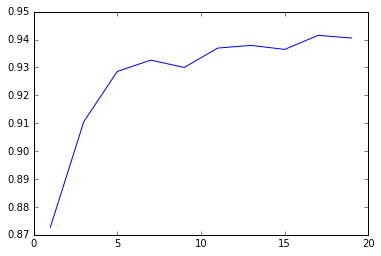

In [25]:
plt.plot(tree_counts, acc_scores)

From looking at the graph, we can choose the number of trees as 10 for a good enough accuray.

Same as above but implementing K-folds:

In [167]:

acc_scores = []
tree_counts = []
for num_trees in xrange(1, 21, 2):
    scores = []
    for train_ind, test_ind in KFold(X.shape[0], n_folds = 5):
        X_train = X[train_ind]
        y_train = y[train_ind]
        X_test = X[test_ind]
        y_test = y[test_ind]
        rf = RandomForestClassifier(n_estimators=num_trees)
        rf.fit(X_train, y_train)
        score = rf.score(X_test, y_test)
        scores.append(score)
    acc_scores.append(np.mean(scores))    
    tree_counts.append(num_trees)

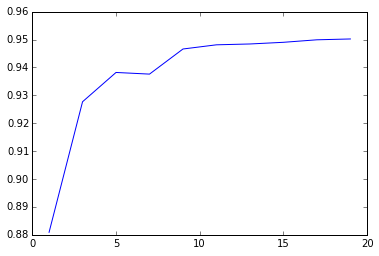

In [168]:
plt.plot(tree_counts, acc_scores)

Now we modify the max features parameter. The default is using sqrt(total # of features). We try all the different possible values (1 to the total number of features) and make a graph of the number of features versus the accuracy score.

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y)
acc_scores = []
feature_counts = []
for num_features in xrange(1, X_train.shape[1]):
    scores = []
    for _ in xrange(5):
        rf = RandomForestClassifier(max_features=num_features)
        rf.fit(X_train, y_train)
        score = rf.score(X_test, y_test)
        scores.append(score)
    acc_scores.append(np.mean(scores))    
    feature_counts.append(num_features)


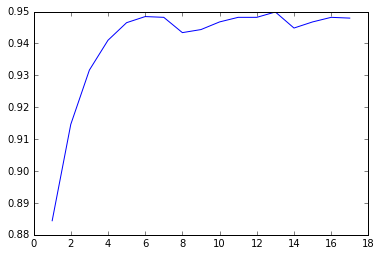

In [27]:
plt.plot(feature_counts, acc_scores)

Looking at the graph, we can pick the number of features to consider as 5.

We run some other classifiers (logistic regression, decision tree, k nearest neighbors) using sklearn's default parameters for all of them. 

In [28]:
for function in [LogisticRegression, KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier]:
    model = function()
    model.fit(X_train,y_train)
    y_predict = model.predict(X_test)
    print "model: ", function.__name__, "accuracy: ", accuracy_score(y_test, y_predict), \
    "precision: ", precision_score(y_test, y_predict), "recall: ", recall_score(y_test, y_predict)
    

model:  LogisticRegression accuracy:  0.860911270983 precision:  0.595744680851 recall:  0.224
model:  KNeighborsClassifier accuracy:  0.870503597122 precision:  0.68085106383 recall:  0.256
model:  DecisionTreeClassifier accuracy:  0.901678657074 precision:  0.659259259259 recall:  0.712
model:  RandomForestClassifier accuracy:  0.938848920863 precision:  0.902173913043 recall:  0.664


We see that Random Forest Classifier as well as Decision Tree Classifier perform the best across all metrics considered. The other two models aren't bad with overall accuracy but have such bad sensitivity and precision that we wouldn't consider using them. 

Now we use the `plot_roc` function to visualize the roc curve of each model.

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from scipy import interp
from sklearn.cross_validation import KFold
from sklearn.preprocessing import StandardScaler


def plot_roc(X, y, clf_class, **kwargs):
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    kf = KFold(len(y), n_folds=5, shuffle=True)
    y_prob = np.zeros((len(y),2))
    mean_tpr = 0.0
    mean_fpr = np.linspace(0, 1, 100)
    all_tpr = []
    for i, (train_index, test_index) in enumerate(kf):
        X_train, X_test = X[train_index], X[test_index]
        y_train = y[train_index]
        clf = clf_class(**kwargs)
        clf.fit(X_train,y_train)
        # Predict probabilities, not classes
        y_prob[test_index] = clf.predict_proba(X_test)
        fpr, tpr, thresholds = roc_curve(y[test_index], y_prob[test_index, 1])
        mean_tpr += interp(mean_fpr, fpr, tpr)
        mean_tpr[0] = 0.0
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, lw=1, label='ROC fold %d (area = %0.2f)' % (i, roc_auc))
    mean_tpr /= len(kf)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    plt.plot(mean_fpr, mean_tpr, 'k--',label='Mean ROC (area = %0.2f)' % mean_auc, lw=2)
    
    plt.plot([0, 1], [0, 1], '--', color=(0.6, 0.6, 0.6), label='Random')
    plt.xlim([-0.05, 1.05])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic')
    plt.legend(loc="lower right")
    plt.show()

/media/ubuntu/6E16B89E16B8692B/miniconda2/envs/projects/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/media/ubuntu/6E16B89E16B8692B/miniconda2/envs/projects/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


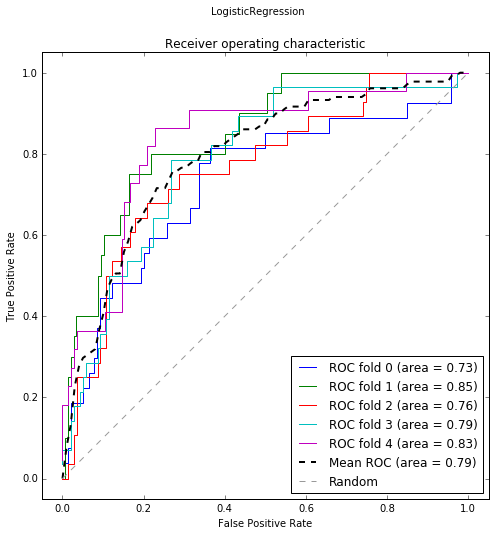

/media/ubuntu/6E16B89E16B8692B/miniconda2/envs/projects/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/media/ubuntu/6E16B89E16B8692B/miniconda2/envs/projects/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


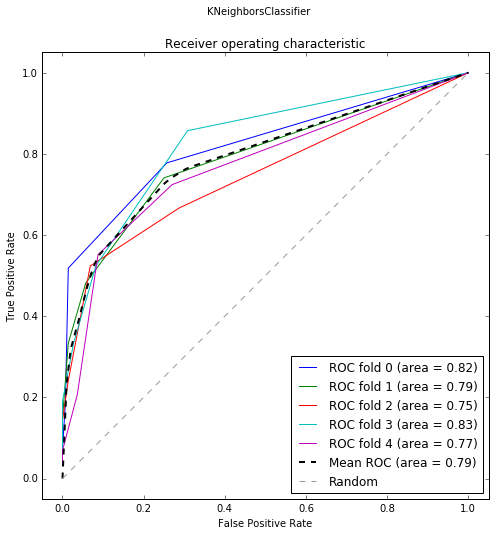

/media/ubuntu/6E16B89E16B8692B/miniconda2/envs/projects/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/media/ubuntu/6E16B89E16B8692B/miniconda2/envs/projects/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


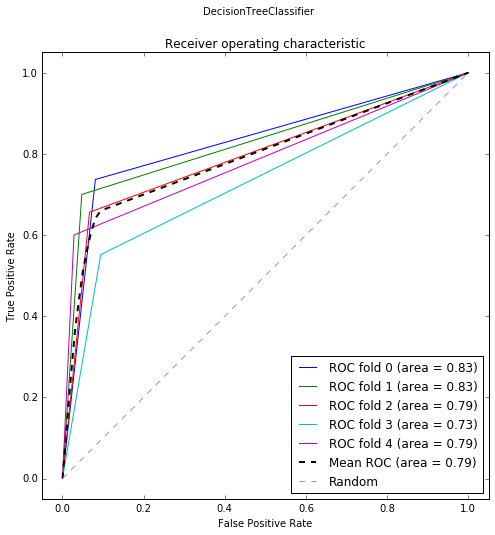

/media/ubuntu/6E16B89E16B8692B/miniconda2/envs/projects/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/media/ubuntu/6E16B89E16B8692B/miniconda2/envs/projects/lib/python2.7/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


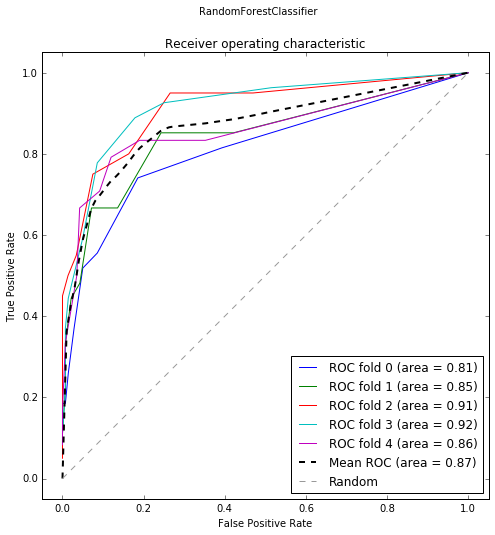

In [38]:
for function in [LogisticRegression, KNeighborsClassifier, DecisionTreeClassifier, RandomForestClassifier]:
    plt.figure(figsize=(8,8))
    plt.suptitle(function.__name__)
    plot_roc(X_test, y_test, function)

Let's say we are try to minimize the false positive rate. Looking to the left part of the ROC curve for each classifier, we are trying to minimize the false positive rate going all the way down to a true positive rate of .2. The Random Forest Classifier and K-Nearest Neighbors classifiers both have a near-0 False Positive rate at this minimum threshold of true positive rate.

Finally we plot the feature importances.

In [39]:
tree1 = rf.estimators_[0]

In [40]:
feat_imp_matrix = np.zeros((len(rf.estimators_), len(rf.feature_importances_)))
i = 0
for tree in rf.estimators_:
    feat_imp_matrix[i] = tree.feature_importances_
    i += 1


In [41]:
feat_means = np.mean(feat_imp_matrix, axis = 0)
feat_stds = np.std(feat_imp_matrix, axis=0, ddof =1)

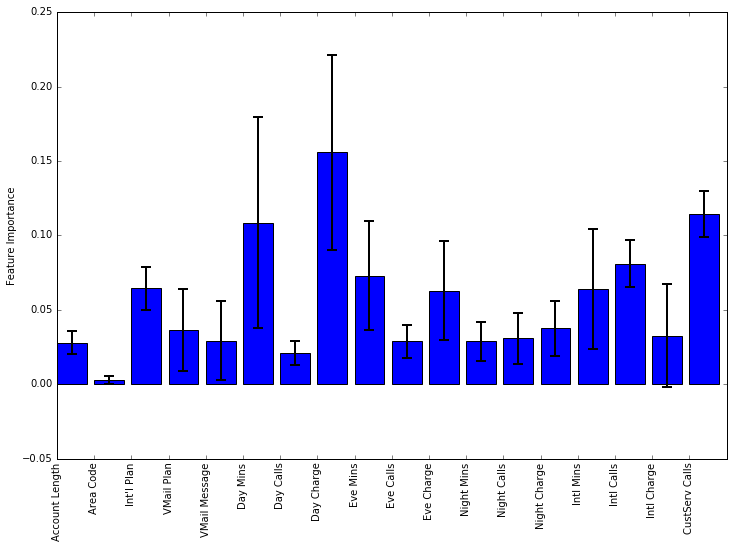

In [42]:
plt.figure(figsize = (12,8))
labels = df.columns
plt.bar(range(18), height = feat_means, yerr = feat_stds, error_kw=dict(ecolor='k', lw=2, capsize=5, capthick=2))
plt.xticks(range(18), labels, rotation='vertical')
plt.ylabel('Feature Importance')
plt.show()

From the plot we see that `Day Charge` and `CustomerServ Calls` are the most important features.